In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

__In this notebook__ I will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/comment_classifier/comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [5]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [6]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [7]:
# task: preprocess each comment in train and test

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier


In [9]:
# find up to k most frequent tokens in texts_train
# sort them by number of occurences (highest first)
k = 10000

bow_vocabulary = {}

for sample in texts_train:
  for word in sample.split():
    if word in bow_vocabulary:
      bow_vocabulary[word] += 1
    else:
      bow_vocabulary[word] = 1

bow_vocabulary = sorted(bow_vocabulary)

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


In [10]:
def text_to_bow(text):

    token_count = np.zeros(len(bow_vocabulary))

    for i in range(len(bow_vocabulary)):
      k = 0
      for word in text.split():
        if bow_vocabulary[i] == word:
          k+=1
      token_count[i] = k


    return np.array(token_count, 'float32')

In [11]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [12]:
X_train_bow

array([[  1.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   6.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 108.,   0., ...,   0.,   0.,   0.],
       [  1.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)

In [13]:
k_max = len(set(' '.join(texts_train).split()))

__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier.
Its a trivial linear model that assumes the independence of input features and computes the coefficients by, well, counting probabilities.

In [16]:
class BinaryNaiveBayes:
    delta = 1.0  # add this to all word counts to smooth probabilities

    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=k) for k = 0,1
        self.p_y = np.array([(len(y) - sum(y))/len(y), sum(y)/len(y)])

        # count occurences of each word in texts with label 1 and label 0 separately
        word_counts_positive = np.zeros(X.shape[1])
        word_counts_negative = np.zeros(X.shape[1])

        for i in range(len(y)):
          if y[i] == 1:
            for j in range(X.shape[1]):
                word_counts_positive[j] += X[i][j]
          if y[i] == 0:
            for j in range(X.shape[1]):
                word_counts_negative[j] += X[i][j]

        # ^-- both must be vectors of shape [vocab_size].

        # finally, lets use those counts to estimate p(x | y = k) for k = 0, 1

        self.p_x_given_positive = np.array([(self.delta + x) / (self.delta*len(word_counts_positive) + sum(word_counts_positive)) for x in word_counts_positive])
        self.p_x_given_negative = np.array([(self.delta + x) / (self.delta*len(word_counts_negative) + sum(word_counts_negative)) for x in word_counts_negative])

        return self

    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}

        score_negative = np.log(self.p_y[0]) + X@[np.log(x) for x in self.p_x_given_negative]
        score_positive = np.log(self.p_y[1]) + X@[np.log(x) for x in self.p_x_given_positive]

        # we can compute total p(x | y=k) with a dot product
        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [17]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [41]:
f_index = bow_vocabulary.index('fuck')  # offensive tweets should contain more of this
assert naive_model.p_x_given_positive[f_index] > naive_model.p_x_given_negative[f_index]

g_index = bow_vocabulary.index('good')  # offensive tweets should contain less of this
assert naive_model.p_x_given_positive[g_index] < naive_model.p_x_given_negative[g_index]

Model accuracy: 0.756


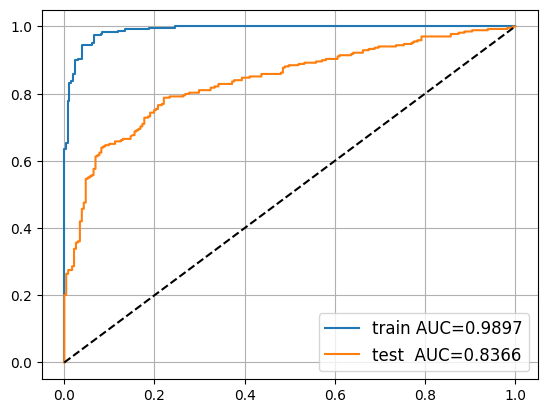

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa.

Let's compute top-25 words that have the __highest__ ratio of ${p(x_i | y=1)} \over {p(x_i | y=0)}$.

In [21]:
probability_ratio = np.array(naive_model.p_x_given_positive / naive_model.p_x_given_negative)
negative = {i:probability_ratio[i] for i in range(len(probability_ratio))}
negative_sorted = sorted(negative.items(), key=lambda x: x[1], reverse=True)
negative_sorted[3]

(4827, 314.7414009803511)

In [43]:
# hint: use naive_model.p_*
probability_ratio = np.array(naive_model.p_x_given_positive / naive_model.p_x_given_negative)

negative = {i:probability_ratio[i] for i in range(len(probability_ratio))}
negative_sorted = sorted(negative.items(), key=lambda x: x[1], reverse=True)

top_negative_words = [bow_vocabulary[i] for i in [negative_sorted[j][0] for j in range(25)]]

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[bow_vocabulary.index(word)]})")

#0	    hitler	(ratio=475.47341740332655)
#1	      heil	(ratio=471.80652729481756)
#2	   offfuck	(ratio=441.24910972390967)
#3	      suck	(ratio=314.7414009803511)
#4	    nigger	(ratio=223.68029661904563)
#5	 j.delanoy	(ratio=220.0134065105367)
#6	      dick	(ratio=187.01139553395618)
#7	      fggt	(ratio=97.78373622690519)
#8	     bitch	(ratio=59.89253843897943)
#9	      fuck	(ratio=53.78105492479786)
#10	      shit	(ratio=44.00268130210734)
#11	      slap	(ratio=44.00268130210734)
#12	   fucking	(ratio=31.779714273744187)
#13	       ass	(ratio=26.89052746239893)
#14	    stupid	(ratio=18.334450542544726)
#15	         =	(ratio=17.53995768570112)
#16	         *	(ratio=17.11215383970841)
#17	   college	(ratio=17.11215383970841)
#18	   asshole	(ratio=15.889857136872093)
#19	         u	(ratio=15.278708785453937)
#20	   bastard	(ratio=14.66756043403578)
#21	       hit	(ratio=14.66756043403578)
#22	         @	(ratio=13.445263731199464)
#23	     idiot	(ratio=13.445263731199464)
#24	 beautiful	

Now lets try something less prehistoric: __Logistic Regression__.

In [23]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(C = 0.2, max_iter=1000)
bow_model.fit(X_train_bow, y_train)

LogisticRegression(C=0.2, max_iter=1000)

Model accuracy: 0.772


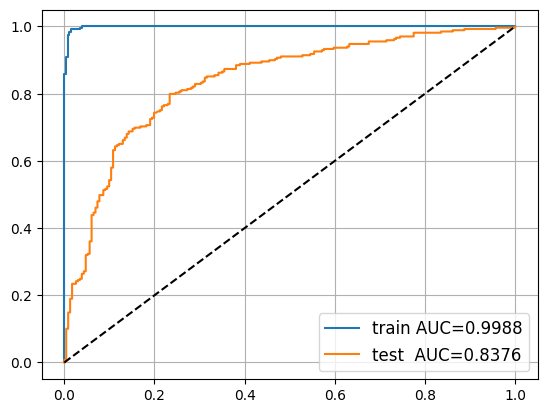

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")

### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }} $$


, where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1).
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

In [26]:
def tfidf(X):
  N = len(X)
  alpha = 1

  ##count_words
  counter = []
  for j in range(X.shape[1]):
    each_word = 0
    for i in range(X.shape[0]):
      if X_train_bow[i][j] != 0:
        each_word+=1
    counter.append(each_word)
    ##

    ##tf-idf weights
  feature_importances = np.zeros((X.shape[0], X.shape[1]))
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      feature_importances[i][j] = X[i][j] * np.log((X.shape[0])/(counter[j] + alpha))

  ##normalize each data sample

  for sample in feature_importances:
    sample/= (sum(sample)+1)

  return feature_importances


In [27]:
x_train_idf = tfidf(X_train_bow)
x_test_idf = tfidf(X_test_bow)

Model accuracy: 0.790


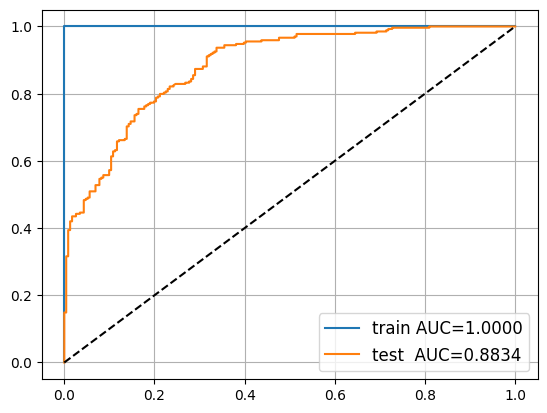

In [36]:
tf_idf_model = LogisticRegression(C = 1000, max_iter=1000)
tf_idf_model.fit(x_train_idf, y_train)

for name, X, y, model in [
    ('train', x_train_idf, y_train, tf_idf_model),
    ('test ', x_test_idf, y_test, tf_idf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(model.predict(x_test_idf) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")


### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings

In [29]:
import gensim.downloader
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [30]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    for word in comment.split():
      if word in embeddings:
        features += embeddings[word]
      else:
        continue

    return features


In [32]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model accuracy: 0.884


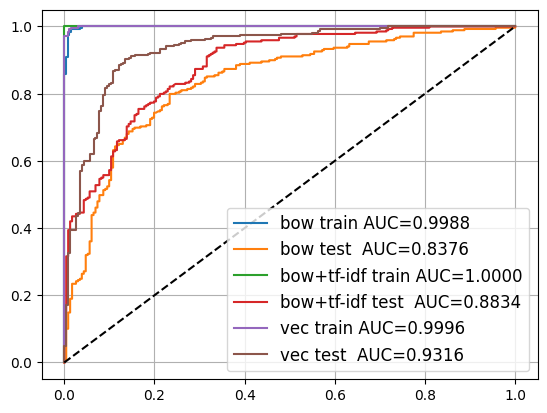

In [40]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('bow+tf-idf train', x_train_idf, y_train, tf_idf_model),
    ('bow+tf-idf test ', x_test_idf, y_test, tf_idf_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()
test_accuracy = np.mean(wv_model.predict(X_test_wv) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")